In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.utils as utils
import seaborn as sns
from collections import Counter

from tqdm import tqdm
import src.dtw as dtw
from joblib import Parallel, delayed
import src.dba as dba
from sklearn.metrics import accuracy_score
from tslearn.barycenters import euclidean_barycenter
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
import pickle
import time

from src.kmedoid import KMedoid
from src.kmean import KMeans
from src.rdm import RDm
from src.agh import AGH

In [2]:
# Path of the train and test dataset
train_set_path = 'UCRArchive_2018/CBF/CBF_TRAIN.tsv'
test_set_path = 'UCRArchive_2018/CBF/CBF_TEST.tsv'

# Extract the time series and classes for train and test set
train_labels, train_ts = utils.extract_ts_from_file(train_set_path)
test_labels, test_ts = utils.extract_ts_from_file(test_set_path)

$$ \textbf{Analyse des données} $$

In [3]:
print(f"L'ensemble d'entrainement est composé de {train_ts.shape[0]} échantillons de longueur {train_ts.shape[1]}")
print(f"L'ensemble de test est composé de {test_ts.shape[0]} échantillons de longueur {test_ts.shape[1]}")

L'ensemble d'entrainement est composé de 30 échantillons de longueur 128
L'ensemble de test est composé de 900 échantillons de longueur 128


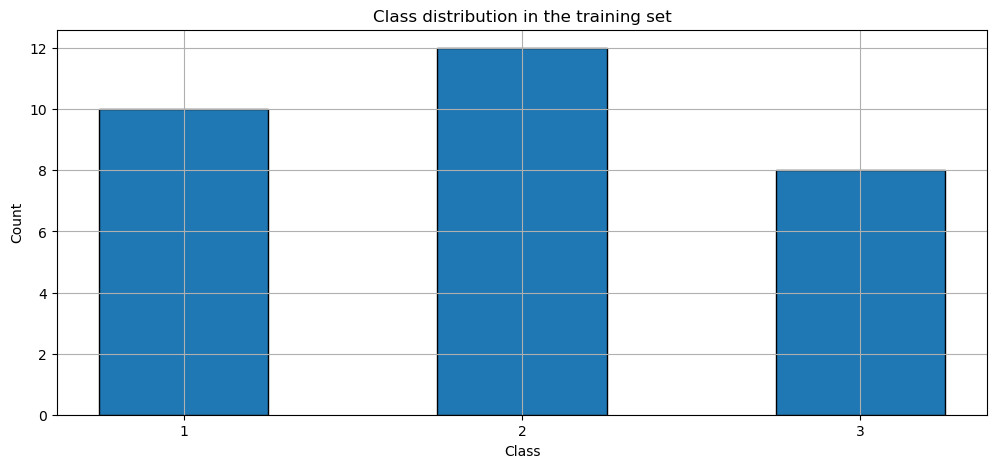

In [4]:
count = Counter(train_labels)

plt.figure(figsize = (12, 5))
plt.grid(True)
plt.bar(count.keys(), count.values(), width = 0.5, edgecolor = 'black')
plt.xlabel("Class")
plt.ylabel("Count")

plt.title("Class distribution in the training set")

plt.xticks([i for i in count.keys()])
plt.show()

In [5]:
EXEC = True
if EXEC :
    def compute_dtw(i, j):
        return i, j, dtw.get_dtw_distance(train_ts[i], train_ts[j])

    train_set_size = len(train_labels)

    DTW_distance_matrix = np.zeros([train_set_size, train_set_size])

    results = Parallel(n_jobs=-1)(delayed(compute_dtw)(i, j) 
                                for i in tqdm(range(train_set_size), disable = False) 
                                for j in range(i, train_set_size))

    # Remplissage de la matrice à partir des résultats
    for i, j, dist in results:
        DTW_distance_matrix[i, j] = dist
        DTW_distance_matrix[j, i] = dist
else : 
    DTW_distance_matrix = np.load('train_dtw_InsectWingbeatSound.npy')

100%|██████████| 30/30 [00:07<00:00,  3.79it/s]


In [6]:
np.save("train_dtw_CBF.npy", DTW_distance_matrix)

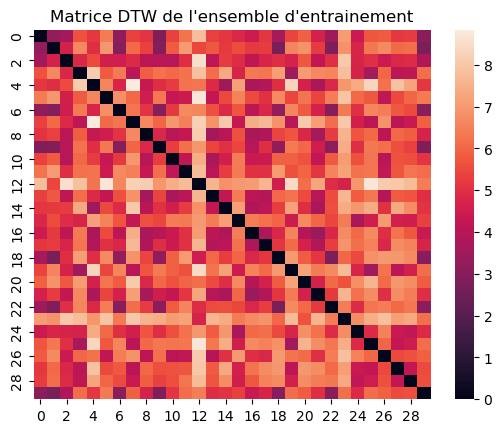

In [7]:
sns.heatmap(DTW_distance_matrix)
plt.title("Matrice DTW de l'ensemble d'entrainement")
plt.show()

In [10]:
a = Counter(train_labels)
print(a)

Counter({2: 12, 1: 10, 3: 8})


In [19]:
nb_class = len(Counter(train_labels).keys())
classes_index = {i:[] for i in Counter(train_labels).keys()}
for i, classe in enumerate(train_labels):
    classes_index[classe].append(i)

# Calcul de la "moyenne" de ces séries en utilisant la DBA et la distance euclidienne
class_dba = np.zeros([nb_class, 128])
class_euc = np.zeros([nb_class, 128])
for i in tqdm(sorted(list(classes_index.keys()))):
    class_dba[i-1] = dba.DBA(X = train_ts, 
                           D = train_ts[classes_index[i],:], 
                           id_D = classes_index[i], 
                           nb_iter = 10, 
                           dtw_matrix = DTW_distance_matrix, 
                           subset_size = len(classes_index[i]))
    
    class_euc[i-1] = np.squeeze(euclidean_barycenter(train_ts[classes_index[i],:]))

100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


KeyError: 0

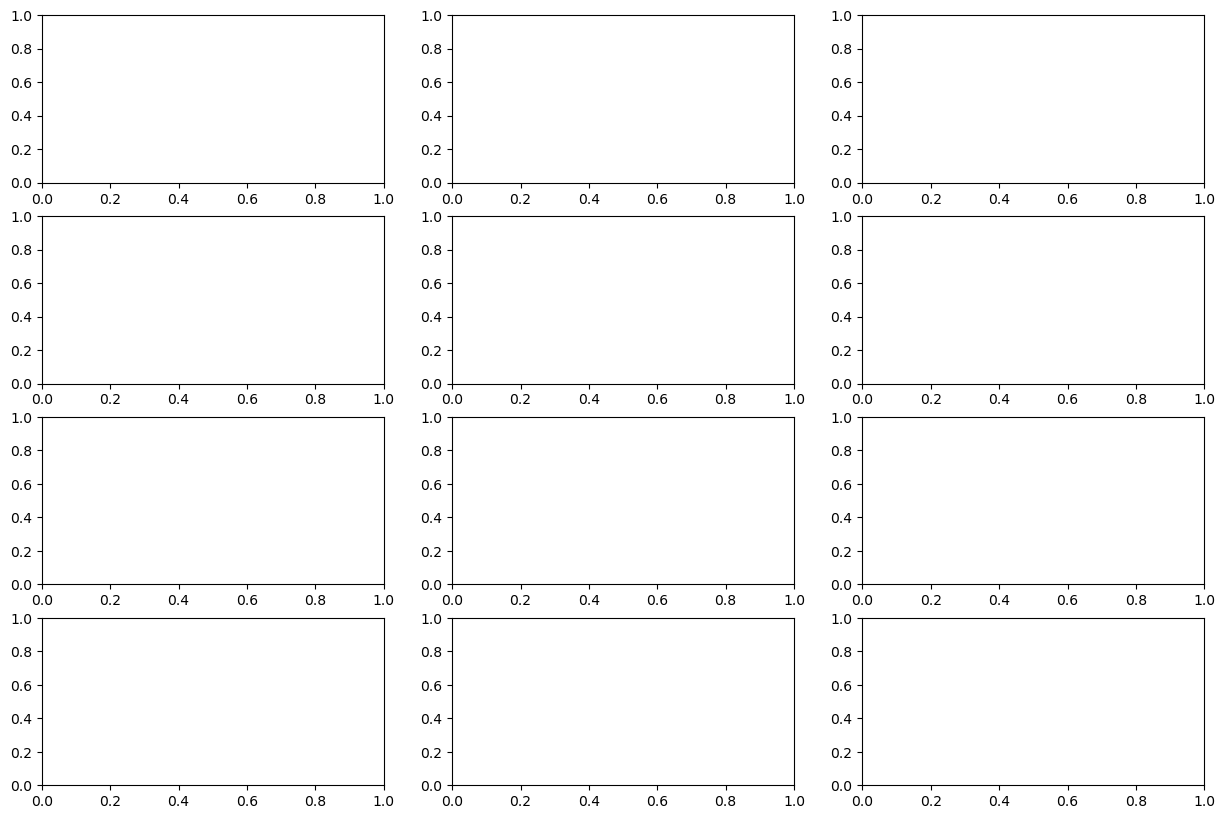

In [ ]:
# Visualisons des échantillons de chacune des 11 classes
fig, axes = plt.subplots(4, 3, figsize=(15, 10)) 
axes = axes.flatten() 

for i in range(nb_class):
    for j in range(len()): 
        axes[i].plot(class_ts[i, j], label=f"Échantillon {j+1}")
    axes[i].set_title(f"Classe {i+1}")
    axes[i].grid(True)
    axes[i].set_xlabel('Time [s]')
    axes[i].set_ylabel('Amplitude')

for k in range(nb_class, 12):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

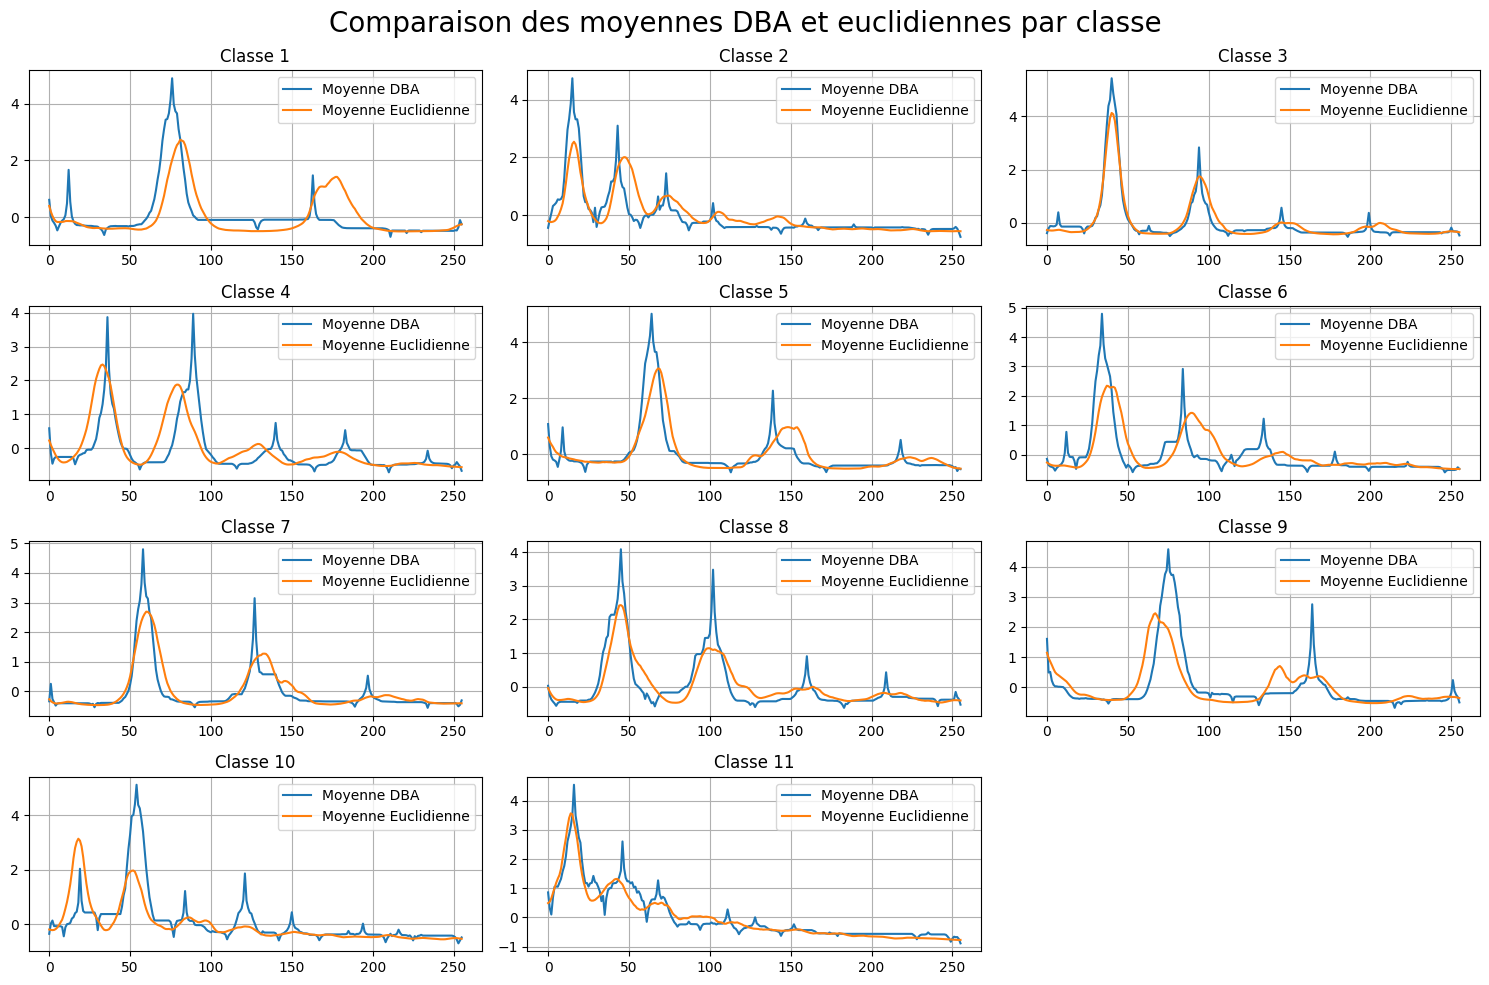

In [11]:
# Comparaison des moyennes euclidiennes et DBA
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(nb_class):
    axes[i].plot(class_dba[i], label='Moyenne DBA')
    axes[i].plot(class_euc[i], label='Moyenne Euclidienne')
    axes[i].set_title(f'Classe {i + 1}')
    axes[i].grid(True)
    axes[i].legend()
    axes[i].grid(True)

for j in range(nb_class, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Comparaison des moyennes DBA et euclidiennes par classe", fontsize = 20)
plt.tight_layout()
plt.show()


$$ \textbf{Evaluation des différentes méthodes} $$

### Condensation des données par K-Means

In [12]:
def get_KMeans_centroids(ts_set, classes_id, n_clusters):

    nb_class = len(classes_id)  # Nombre de classes
    t = ts_set.shape[1]         # Longueur des séries temporelles

    # Initialisation de l'array des centroides
    centroids = np.zeros([nb_class, n_clusters, t])

    for idx, id_class in tqdm(enumerate(classes_id)):
        print(f"Computing centroid for class{id_class}")
        # Récupération de la classe associé
        class_ts = train_ts[train_labels == id_class]
        class_idx = np.where(train_labels == id_class)
        
        class_dtw_mat = dtw.extract_sub_dtw_mat(DTW_distance_matrix, list(class_idx[0]))
        KM_Classifier = KMeans(nb_clusters = n_clusters, max_iter = 20, eps = 0.1)
        KM_Classifier.fit(class_ts, class_dtw_mat)

        centroids[idx] = KM_Classifier.centroids

    return centroids

# Pour paralléliser
def compute_centroids_for_n_clusters(n_clusters, train_ts, classes_id):
    return n_clusters, get_KMeans_centroids(
        ts_set=train_ts,
        classes_id=classes_id,
        n_clusters=n_clusters
    )

In [17]:
# Récupération des différentes classes du dataset
classes_id = np.unique(train_labels)

# Récupération des centroides pour différentes valeurs de n_clusters
n_clusters = np.arange(1, 11)
results = Parallel(n_jobs=-1)(delayed(compute_centroids_for_n_clusters)(
    n_clusters, train_ts, classes_id
) for n_clusters in n_clusters)

# Stockage des différents centroides dans un dictionnaire
all_centroids = {n_clusters: centroids for n_clusters, centroids in results}

In [18]:
with open("k_means_centroids.pkl", "wb") as file:
    pickle.dump(all_centroids, file)

In [20]:
k_means_acc = []
k_means_time = []

for i in tqdm(range(1, 11)):
    # Reshape the centroid array
    reshaped_centroid = all_centroids[i].reshape(nb_class*i, -1)
    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * i)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw')   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    k_means_time.append(end_time - start_time)
    k_means_acc.append(accuracy_score(test_labels, predictions))

    print(f"Accuracy pour {i} clusters : {k_means_acc[-1]} | Complexité temporelle : {k_means_time[-1]}")

 10%|█         | 1/10 [00:10<01:38, 10.92s/it]

Accuracy pour 1 clusters : 0.2717171717171717 | Complexité temporelle : 10.883428812026978


 20%|██        | 2/10 [00:27<01:52, 14.05s/it]

Accuracy pour 2 clusters : 0.31565656565656564 | Complexité temporelle : 16.232166528701782


 30%|███       | 3/10 [00:51<02:11, 18.75s/it]

Accuracy pour 3 clusters : 0.32171717171717173 | Complexité temporelle : 24.34182834625244


 40%|████      | 4/10 [01:23<02:22, 23.83s/it]

Accuracy pour 4 clusters : 0.31767676767676767 | Complexité temporelle : 31.601567029953003


 50%|█████     | 5/10 [02:04<02:30, 30.14s/it]

Accuracy pour 5 clusters : 0.33080808080808083 | Complexité temporelle : 41.315162897109985


 60%|██████    | 6/10 [02:52<02:25, 36.29s/it]

Accuracy pour 6 clusters : 0.35808080808080806 | Complexité temporelle : 48.23224759101868


 70%|███████   | 7/10 [03:48<02:07, 42.61s/it]

Accuracy pour 7 clusters : 0.35404040404040404 | Complexité temporelle : 55.624258279800415


 80%|████████  | 8/10 [04:52<01:39, 49.55s/it]

Accuracy pour 8 clusters : 0.353030303030303 | Complexité temporelle : 64.38214135169983


 90%|█████████ | 9/10 [06:07<00:57, 57.36s/it]

Accuracy pour 9 clusters : 0.35 | Complexité temporelle : 74.54070854187012


100%|██████████| 10/10 [07:26<00:00, 44.62s/it]

Accuracy pour 10 clusters : 0.3515151515151515 | Complexité temporelle : 78.90884709358215


### Condensation des données par Random selection

In [21]:
def get_Rdm_centroids(ts_set, classes_id, n_clusters):

    nb_class = len(classes_id)  # Nombre de classes
    t = ts_set.shape[1]         # Longueur des séries temporelles

    # Initialisation de l'array des centroides
    centroids = np.zeros([nb_class, n_clusters, t])

    for idx, id_class in tqdm(enumerate(classes_id)):
        print(f"Computing Random centroids for class{id_class}")
        # Récupération de la classe associé
        class_ts = train_ts[train_labels == id_class]
        
        KM_Classifier = RDm(nb_clusters = n_clusters)
        KM_Classifier.fit(class_ts)

        centroids[idx] = KM_Classifier.centroids

    return centroids

In [22]:
rdm_acc = []
rdm_time = []

for n_clusters in range(1, 11) :
    rdm_centroids = get_Rdm_centroids(ts_set = train_ts, 
                                  classes_id = classes_id, 
                                  n_clusters = n_clusters)
    
    # Reshape the centroid array
    reshaped_centroid = rdm_centroids.reshape(nb_class * n_clusters, -1)

    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * n_clusters)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw')   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    rdm_acc.append(accuracy_score(test_labels, predictions))
    rdm_time.append(end_time - start_time)

    print(f"Accuracy pour {n_clusters} clusters : {rdm_acc[-1]} | Prediction time : {rdm_time[-1]}")
    

11it [00:00, 1437.57it/s]


Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11
Accuracy pour 1 clusters : 0.20505050505050504 | Prediction time : 8.780299425125122


11it [00:00, 10016.79it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 2 clusters : 0.2409090909090909 | Prediction time : 16.667690992355347


11it [00:00, 7238.37it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 3 clusters : 0.2631313131313131 | Prediction time : 25.363391876220703


11it [00:00, 10307.72it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 4 clusters : 0.3085858585858586 | Prediction time : 32.42709469795227


11it [00:00, 3140.73it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 5 clusters : 0.2924242424242424 | Prediction time : 39.13849759101868


11it [00:00, 3569.90it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 6 clusters : 0.29444444444444445 | Prediction time : 44.86126780509949


11it [00:00, 7399.73it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 7 clusters : 0.301010101010101 | Prediction time : 51.86010479927063


11it [00:00, 5280.68it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 8 clusters : 0.31313131313131315 | Prediction time : 60.17424941062927


11it [00:00, 10218.68it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 9 clusters : 0.31212121212121213 | Prediction time : 64.5496141910553


11it [00:00, 6520.26it/s]

Computing Random centroids for class1
Computing Random centroids for class2
Computing Random centroids for class3
Computing Random centroids for class4
Computing Random centroids for class5
Computing Random centroids for class6
Computing Random centroids for class7
Computing Random centroids for class8
Computing Random centroids for class9
Computing Random centroids for class10
Computing Random centroids for class11


Accuracy pour 10 clusters : 0.32727272727272727 | Prediction time : 71.20277619361877


### Condensation des données par K-Medoid

In [23]:
def get_KMedoid_centroids(ts_set, classes_id, n_clusters):

    nb_class = len(classes_id)  # Nombre de classes
    t = ts_set.shape[1]         # Longueur des séries temporelles

    # Initialisation de l'array des centroides
    centroids = np.zeros([nb_class, n_clusters, t])

    for idx, id_class in tqdm(enumerate(classes_id)):
        print(f"Computing centroid for class{id_class}")
        # Récupération de la classe associé
        class_ts = train_ts[train_labels == id_class]
        class_idx = np.where(train_labels == id_class)
        
        class_dtw_mat = dtw.extract_sub_dtw_mat(DTW_distance_matrix, list(class_idx[0]))
        KMed_Classifier = KMedoid(nb_clusters = n_clusters, max_iter = 10, eps = 0.1)
        KMed_Classifier.fit(class_ts, class_dtw_mat)

        centroids[idx] = KMed_Classifier.centroids

    return centroids

In [24]:
kmed_acc = []
kmed_time = []

for n_clusters in tqdm(range(1, 11)):
    # Reshape the centroid array
    centroids = get_KMedoid_centroids(ts_set = train_ts, 
                                      classes_id = classes_id, 
                                      n_clusters = n_clusters)
    
    reshaped_centroid = centroids.reshape(nb_class*n_clusters, -1)
    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * n_clusters)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw')   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    kmed_acc.append(accuracy_score(test_labels, predictions))
    kmed_time.append(end_time - start_time)

    print(f"Accuracy pour {n_clusters} clusters : {kmed_acc[-1]} | Prediction time : {kmed_time[-1]}")


11it [00:00, 477.31it/s]0:00<?, ?it/s]


Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 

 10%|█         | 1/10 [00:07<01:09,  7.77s/it]

Accuracy pour 1 clusters : 0.23232323232323232 | Prediction time : 7.740238666534424


11it [00:00, 891.04it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 20%|██        | 2/10 [00:22<01:37, 12.14s/it]

Accuracy pour 2 clusters : 0.302020202020202 | Prediction time : 15.172267198562622


11it [00:00, 1047.29it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 30%|███       | 3/10 [00:44<01:54, 16.41s/it]

Accuracy pour 3 clusters : 0.3015151515151515 | Prediction time : 21.459296226501465


11it [00:00, 1014.54it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 40%|████      | 4/10 [01:13<02:07, 21.24s/it]

Accuracy pour 4 clusters : 0.31717171717171716 | Prediction time : 28.62587881088257


11it [00:00, 755.00it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 50%|█████     | 5/10 [01:50<02:14, 26.93s/it]

Accuracy pour 5 clusters : 0.2964646464646465 | Prediction time : 36.99252271652222


11it [00:00, 500.68it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 60%|██████    | 6/10 [03:09<02:58, 44.73s/it]

Accuracy pour 6 clusters : 0.33181818181818185 | Prediction time : 79.23537826538086


11it [00:00, 704.41it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 70%|███████   | 7/10 [04:00<02:20, 46.79s/it]

Accuracy pour 7 clusters : 0.30757575757575756 | Prediction time : 51.01394200325012


11it [00:00, 644.01it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 80%|████████  | 8/10 [05:07<01:46, 53.14s/it]

Accuracy pour 8 clusters : 0.31212121212121213 | Prediction time : 66.69177341461182


11it [00:00, 489.74it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


 90%|█████████ | 9/10 [06:19<00:59, 59.05s/it]

Accuracy pour 9 clusters : 0.3373737373737374 | Prediction time : 72.03341865539551


11it [00:00, 403.27it/s]

Computing centroid for class1
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class2
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class3
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class4
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class5
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class6
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class7
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class8
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class9
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class10
Convergence criterion satisfied before reaching 10 iterations
Computing centroid for class11
Convergence criterion satisfied before reaching 


100%|██████████| 10/10 [07:35<00:00, 45.53s/it]

Accuracy pour 10 clusters : 0.32323232323232326 | Prediction time : 76.03760051727295


### AGH

In [25]:
def get_AGH_centroids(ts_set, classes_id, n_clusters):

    nb_class = len(classes_id)  # Nombre de classes
    t = ts_set.shape[1]         # Longueur des séries temporelles

    # Initialisation de l'array des centroides
    centroids = np.zeros([nb_class, n_clusters, t])

    for idx, id_class in tqdm(enumerate(classes_id)):
        print(f"Computing centroid for class{id_class}")
        # Récupération de la classe associé
        class_ts = train_ts[train_labels == id_class]
        class_idx = np.where(train_labels == id_class)
        
        class_dtw_mat = dtw.extract_sub_dtw_mat(DTW_distance_matrix, list(class_idx[0]))
        AGH_Classifier = AGH(nb_clusters = n_clusters, max_iter = 10, eps = 0.1)
        AGH_Classifier.fit(class_ts, class_dtw_mat)

        centroids[idx] = AGH_Classifier.centroids

    return centroids

In [28]:
agh_acc = []
agh_time = []

for n_clusters in tqdm(range(1, 11)):
    # Reshape the centroid array
    centroids = get_AGH_centroids(ts_set = train_ts, 
                                classes_id = classes_id, 
                                n_clusters = n_clusters)
    
    reshaped_centroid = centroids.reshape(nb_class*n_clusters, -1)
    # Create a label vector associated to the centroid array
    labels = []
    for id_class in range(1, nb_class+1):
        labels.extend([id_class] * n_clusters)

    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = 'dtw')   
    knn_dtw.fit(reshaped_centroid, labels)

    start_time = time.time()
    predictions = knn_dtw.predict(test_ts)
    end_time = time.time()

    agh_acc.append(accuracy_score(test_labels, predictions))
    agh_time.append(end_time - start_time)

    print(f"Accuracy pour {n_clusters} clusters : {agh_acc[-1]} | Prediction time : {agh_time[-1]}")

  0%|          | 0/10 [00:00<?, ?it/s]

Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [01:00,  5.54s/it]
 10%|█         | 1/10 [01:08<10:16, 68.51s/it]

Accuracy pour 1 clusters : 0.2383838383838384 | Prediction time : 7.512804985046387


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [01:05,  6.00s/it]
 20%|██        | 2/10 [02:29<10:05, 75.67s/it]

Accuracy pour 2 clusters : 0.22373737373737373 | Prediction time : 14.722482681274414


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [01:19,  7.23s/it]
 30%|███       | 3/10 [04:11<10:14, 87.81s/it]

Accuracy pour 3 clusters : 0.22121212121212122 | Prediction time : 22.773565530776978


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [01:36,  8.73s/it]
 40%|████      | 4/10 [06:17<10:18, 103.05s/it]

Accuracy pour 4 clusters : 0.23535353535353534 | Prediction time : 30.382107496261597


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [01:45,  9.60s/it]
 50%|█████     | 5/10 [08:39<09:45, 117.06s/it]

Accuracy pour 5 clusters : 0.25555555555555554 | Prediction time : 36.29824995994568


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [01:55, 10.46s/it]
 60%|██████    | 6/10 [11:17<08:44, 131.04s/it]

Accuracy pour 6 clusters : 0.2601010101010101 | Prediction time : 43.091331481933594


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [02:13, 12.09s/it]
 70%|███████   | 7/10 [14:20<07:23, 147.80s/it]

Accuracy pour 7 clusters : 0.27474747474747474 | Prediction time : 49.289125204086304


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [02:10, 11.86s/it]
 80%|████████  | 8/10 [17:25<05:19, 159.75s/it]

Accuracy pour 8 clusters : 0.2813131313131313 | Prediction time : 54.87866139411926


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [02:23, 13.02s/it]
 90%|█████████ | 9/10 [20:53<02:54, 174.80s/it]

Accuracy pour 9 clusters : 0.29343434343434344 | Prediction time : 64.66128468513489


Computing centroid for class1


Computing centroid for class2


Computing centroid for class3


Computing centroid for class4


Computing centroid for class5


Computing centroid for class6


Computing centroid for class7


Computing centroid for class8


Computing centroid for class9


Computing centroid for class10


Computing centroid for class11


11it [02:29, 13.62s/it]
100%|██████████| 10/10 [24:32<00:00, 147.29s/it]

Accuracy pour 10 clusters : 0.2909090909090909 | Prediction time : 69.54329419136047


In [44]:
one_nn_clf = KNeighborsTimeSeriesClassifier(n_neighbors = 1, metric = "dtw")

one_nn_clf.fit(train_ts, train_labels)

start_time = time.time()
predictions = one_nn_clf.predict(test_ts)
end_time = time.time()

print(f"1-NN DTW accuracy : {accuracy_score(test_labels, predictions)} | Prediction time : {end_time - start_time}")

1-NN DTW accuracy : 0.35505050505050506 | Prediction time : 184.12432050704956


In [43]:
1-accuracy_score(test_labels, predictions)

0.41515151515151516

In [31]:
one_nn_error_rate = 1 - accuracy_score(test_labels, predictions)

$$\textbf{Visualisation des résultats}$$

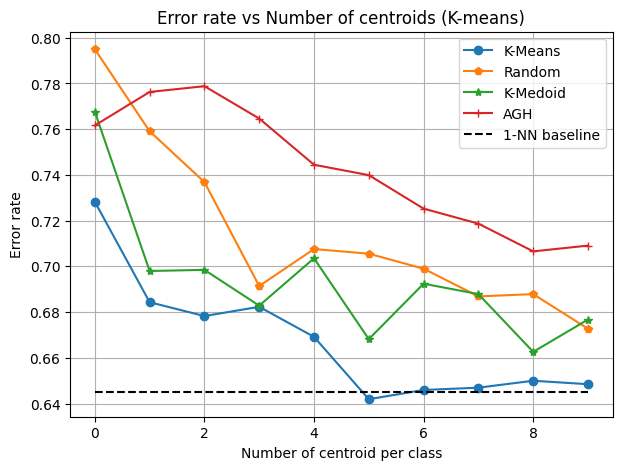

In [33]:
error_rate_km = np.ones([10]) - k_means_acc
error_rate_rdm = np.ones([10]) - rdm_acc
error_rate_k_med = np.ones([10]) - kmed_acc
error_rate_agh = np.ones([10]) - agh_acc

plt.figure(figsize = (7, 5))
plt.plot(error_rate_km, marker = 'o', label = "K-Means")
plt.plot(error_rate_rdm, marker = 'p', label = 'Random')
plt.plot(error_rate_k_med, marker ='*', label = 'K-Medoid')
plt.plot(error_rate_agh, marker = '+', label = 'AGH')
plt.plot(one_nn_error_rate*np.ones([10]), linestyle = '--', label = '1-NN baseline', color = 'black')
plt.xlabel('Number of centroid per class')
plt.ylabel('Error rate')
plt.grid(True)
plt.title('Error rate vs Number of centroids (K-means)')
plt.legend()
plt.show()